# Potential energy surfaces of OCS

The datasets for potential energy surfaces (PESs) for various electronic states of OCS
have been calculated in the following papers:

- Schmidt et al., _J. Chem. Phys._ __136__, 131101 (2012)
- Schmidt et al., _J. Chem. Phys._ __137__, 054313 (2012)
- Schmidt et al., _Atmos. Chem. Phys._ __13__, 1511 (2013)
- McBane et al., _J. Chem. Phys._ __138__, 094314 (2013)

These datasets are organized within ASCII files, located in the 'potential_data' folder, for example, file 'ocs-singlet-ap.dat'.
These files contain PES data for different electronic states defined on a grid of Jacobi coordinates
$r_\text{S}$, $r_\text{CO}$, $\theta$.

Usually, such _ab initio_ data for PES for each electronic state is fitted by an analytical function - power-series expansion around some refrence geometry.
Here, to save time, we _fit_ PESs for different states using regular grid interpolator with cubic splines (function `interpolate`).

In [1]:
import import_ipynb

In [2]:
from ocs_coordinates import (
    jacobi_to_cartesian_batch,
    valence_to_cartesian_batch,
    cartesian_to_valence_batch,
    cartesian_to_jacobi_batch,
)
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from collections import namedtuple
import scipy.constants as constants
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

importing Jupyter notebook from ocs_coordinates.ipynb
Test serial computation of G-matrix ...
G.shape: (9, 9)
G vibrational:
 [[ 2.25885729e+00  1.07628682e-17 -3.59498837e-32]
 [ 1.07628682e-17  4.91747847e+00 -2.05710026e-32]
 [-3.59498837e-32 -2.05710026e-32  7.17633576e+00]]
Test computation of G-matrix on batch of 100 points ...
G.shape: (100, 9, 9)


In [3]:
# Matplotlib settings
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams["figure.figsize"] = (6, 6)

# Physics units conversion factors
bohr_to_angstrom = constants.value("atomic unit of length") / 1e-10
hartree_to_ev = constants.value("hartree-electron volt relationship")

The `interpolate` function interpolates PES data stored in ASCII data files.
It requires three input parameters:
1. the name of the ASCII data file,
2. the column index where the energies of the target state are recorded,
3. an optional label for the state.

It returns an object with the attributes:
- `pes`: the interpolating function for the PES,
- `min` and `max`: the minimum and maximum coordinate values present in the dataset,
- `eq` and `e0`: the coordinates and the corresponding energy of the data point with the lowest energy, respectively,
- `label`: the label for the state.

In [4]:
def interpolate(file_name: str, col_index: int = 0, label: str = None):
    print(
        "\nRead potential data from file:", file_name, ", state col. index:", col_index
    )
    pes = np.loadtxt(file_name)
    r_S = pes[:, 0] * bohr_to_angstrom
    r_CO = pes[:, 1] * bohr_to_angstrom
    theta = pes[:, 2] * np.pi / 180.0
    sort_index = np.lexsort((r_S, r_CO, theta))
    pes = pes[sort_index, :]
    pes_values = pes[:, col_index + 3]
    min_index = sort_index[np.argmin(pes_values)]
    eq_coo = np.array([r_S[min_index], r_CO[min_index], theta[min_index]])
    eq_enr = pes_values[min_index]

    r_S = np.unique(r_S)
    r_CO = np.unique(r_CO)
    theta = np.unique(theta)

    pes_values = pes_values.reshape((len(theta), len(r_CO), len(r_S)))
    pes = RegularGridInterpolator(
        (theta, r_CO, r_S),
        pes_values,
        method="cubic",
        bounds_error=False,
        fill_value=None,
    )
    min_coo = np.array([np.min(r_S), np.min(r_CO), np.min(theta)])
    max_coo = np.array([np.max(r_S), np.max(r_CO), np.max(theta)])

    find_min = minimize(
        pes,
        eq_coo[[2, 1, 0]],
        bounds=[
            [el1, el2] for (el1, el2) in zip(min_coo[[2, 1, 0]], max_coo[[2, 1, 0]])
        ],
    )
    eq_coo = find_min.x
    eq_enr = pes(eq_coo)
    eq_coo = eq_coo[[2, 1, 0]]
    if find_min.success:
        print(
            "min and max of coordinates present in the dataset:",
            min_coo.round(4),
            max_coo.round(4),
        )
        print("min on interpolated function:", eq_coo.round(4), eq_enr.round(4))

        # compute second-order derivatives of potential at equilibrium
        # using finite-differences (7-point formula for second derivative)
        h = 0.001
        fdn_step = np.array(
            [3 * h, 2 * h, h, 0.0, -h, -2 * h, -3 * h], dtype=np.float64
        )
        fdn_coef = np.array(
            [2.0, -27.0, 270.0, -490.0, 270.0, -27.0, 2.0], dtype=np.float64
        )
        fdn_denom = 180.0
        deriv2 = []
        for icoo in range(len(eq_coo)):
            coo = np.array(np.broadcast_to(eq_coo, (len(fdn_step), len(eq_coo))))
            coo[:, icoo] = [eq_coo[icoo] + step for step in fdn_step]
            deriv2.append(np.dot(pes(coo[:, [2, 1, 0]]), fdn_coef) / (fdn_denom * h**2))

    if label is None:
        label = (f"{file_name}, col. {col_index}",)

    pes_collection = {
        f"pes": lambda x: pes(x[:, [2, 1, 0]]),
        "min": np.array(min_coo),
        "max": np.array(max_coo),
        "eq": np.array(eq_coo),
        "e0": np.array(eq_enr),
        "deriv2": np.array(deriv2),
        "label": label,
    }
    return namedtuple("pes", pes_collection.keys())(*pes_collection.values())

## Load PESs for all states present in ASCII files

In [5]:
# list of tuples containing as elements:
#   file name, number of states recorded in file, list of labels for each state
file_list = [
    ("ocs-X-state-pes_1_0.dat", 1, ("$X=1^1A'$",)),
    ("ocs-singlet-ap.dat", 3, ("$1^1A'$", "$2^1A'$", "$3^1A'$")),
    ("ocs-singlet-app.dat", 3, ("$1^1A''$", "$2^1A''$", "$3^1A''$")),
    ("ocs-triplet-ap.dat", 3, ("$1^3A'$", "$2^3A'$", "$3^3A'$")),
    ("ocs-triplet-app.dat", 3, ("$1^3A''$", "$2^3A''$", "$3^3A''$")),
]

# load all potentials and store in list
potentials = [
    interpolate(f"potential_data/{file}", col_ind, label)
    for (file, no_cols, labels) in file_list
    for (col_ind, label) in zip(range(no_cols), labels)
]


Read potential data from file: potential_data/ocs-X-state-pes_1_0.dat , state col. index: 0
min and max of coordinates present in the dataset: [1.8521 0.9525 0.0175] [2.6459 1.3759 1.0472]
min on interpolated function: [2.2303 1.1606 0.0175] [-510.9671]

Read potential data from file: potential_data/ocs-singlet-ap.dat , state col. index: 0
min and max of coordinates present in the dataset: [1.6934 0.9525 0.0175] [5.2918 1.905  3.1241]
min on interpolated function: [2.2485 1.1613 0.0213] [-510.9678]

Read potential data from file: potential_data/ocs-singlet-ap.dat , state col. index: 1
min and max of coordinates present in the dataset: [1.6934 0.9525 0.0175] [5.2918 1.905  3.1241]
min on interpolated function: [2.2015 1.1755 0.8369] [-510.8233]

Read potential data from file: potential_data/ocs-singlet-ap.dat , state col. index: 2
min and max of coordinates present in the dataset: [1.6934 0.9525 0.0175] [5.2918 1.905  3.1241]
min on interpolated function: [5.2916 1.1342 1.2218] [-510.8

## Plot 1D cuts along the $r_\text{S}$ coordinate for each state

Plot 1D cuts along r_S coordinate


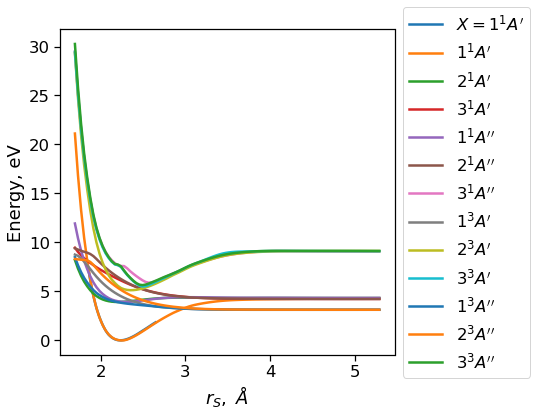

In [6]:
for potential in potentials:

    mesh = np.meshgrid(
        np.linspace(potential.min[0], potential.max[0], 100),
        np.array([potential.eq[1]]),
        np.array([potential.eq[2]]),
    )
    grid = np.stack([elem.ravel() for elem in mesh], axis=-1)
    v = potential.pes(grid)
    plt.plot(grid[:, 0], (v - potentials[0].e0) * hartree_to_ev, label=potential.label)

print("Plot 1D cuts along r_S coordinate")
plt.xlabel("$r_S,~\AA$")
plt.ylabel("Energy, eV")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

## Plot 1D cuts along the $\theta$ coordinate for each state

Plot 1D cuts along theta coordinate


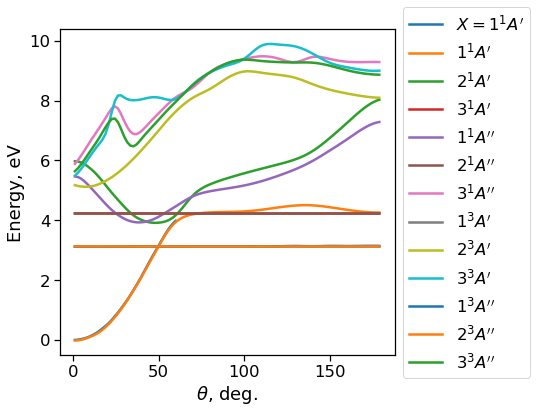

In [7]:
for potential in potentials:

    mesh = np.meshgrid(
        np.array([potential.eq[0]]),
        np.array([potential.eq[1]]),
        np.linspace(potential.min[2], potential.max[2], 100),
    )
    grid = np.stack([elem.ravel() for elem in mesh], axis=-1)
    v = potential.pes(grid)
    plt.plot(
        grid[:, 2] * 180 / np.pi,
        (v - potentials[0].e0) * hartree_to_ev,
        label=potential.label,
    )

print("Plot 1D cuts along theta coordinate")
plt.xlabel("$\\theta$, deg.")
plt.ylabel("Energy, eV")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

## The role of vibrational coordinates: Jacobi vs valence-bond

<img src="assets/images/ocs_valence.png" alt="Alternative text" height="150" />
<img src="assets/images/ocs_jacobi.png" alt="Alternative text" height="150" />

Which coordinates, _Jacobi_ or _valence-bond_ coordinates,
lead to more effective decoupling in the PES for different electronic states?

Visualise this by plotting 2D sections along the $r_\text{S}$ and $\theta$ Jacobi coordinates
and compare them with sections along the $r_\text{CS}$ and $\alpha$ valence-bond coordinates
for PES of selected electronic state.

First, plot 2D section along Jacobi coordinates $r_\text{S}$ and $\theta$.

Plot 2D section along Jacobi (r_S, theta) coordinates


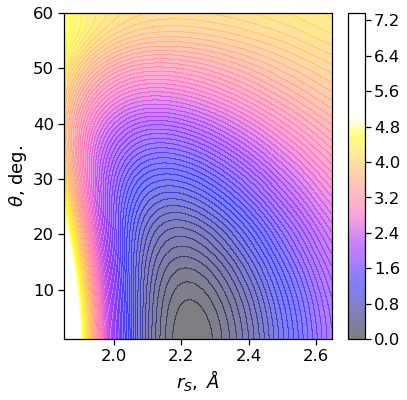

In [11]:
# specify index of electronic state
state_ind = 0
potential = potentials[state_ind]

# mesh grid in Jacobi coordinates
mesh = np.meshgrid(
    np.linspace(potential.min[0], potential.max[0], 100),
    np.array([potential.eq[1]]),
    np.linspace(potential.min[2], potential.max[2], 100),
)

# Cartesian-product grid
grid = np.stack([elem.ravel() for elem in mesh], axis=-1)

# evaluate potential
v = potential.pes(grid)
v = v.reshape(100, 100)

print("Plot 2D section along Jacobi (r_S, theta) coordinates")
plt.contourf(
    mesh[0][0, :, :],
    mesh[2][0, :, :] * 180 / np.pi,
    (v - potential.e0) * hartree_to_ev,
    100,
    alpha=0.5,
    cmap=cm.gnuplot2,
    vmin=0,
    vmax=5,
)
plt.xlabel("$r_S,~\AA$")
plt.ylabel("$\\theta$, deg.")
plt.colorbar()
plt.show()

Plot 2D section along valence-bond coordiantes $r_\text{CS}$ and $\alpha$.

Plot 2D section along valence-bond (r_CS, alpha) coordinates


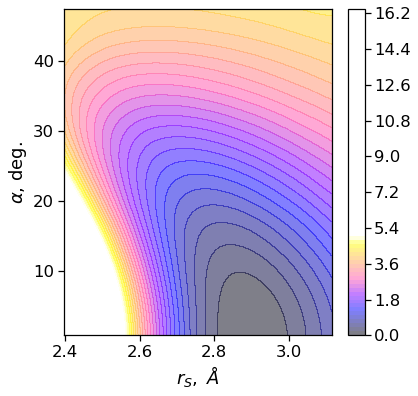

In [12]:
# specify index of electronic state
state_ind = 0
potential = potentials[state_ind]

# convert min, max, and equilibrium values of Jacobi coordinates to valence-bond coordinates
valence_min, valence_max, valence_eq = cartesian_to_valence_batch(
    jacobi_to_cartesian_batch(np.array([potential.min, potential.max, potential.eq]))
)

# mesh grid in valence-bond coordinates
mesh = np.meshgrid(
    np.array([valence_eq[0]]),
    np.linspace(valence_min[1], valence_max[1], 100),
    np.linspace(valence_min[2], valence_max[2], 100),
)

# Cartesian-product grid
grid = np.stack([elem.ravel() for elem in mesh], axis=-1)

# evaluate potential: valence-bond -> cartesian -> Jacobi -> potential
v = potential.pes(cartesian_to_jacobi_batch(valence_to_cartesian_batch(grid)))
v = v.reshape(100, 100)

print("Plot 2D section along valence-bond (r_CS, alpha) coordinates")
plt.contourf(
    mesh[1][:, 0, :],
    mesh[2][:, 0, :] * 180 / np.pi,
    (v - potential.e0) * hartree_to_ev,
    100,
    alpha=0.5,
    cmap=cm.gnuplot2,
    vmin=0,
    vmax=5,
)
plt.xlabel("$r_S,~\AA$")
plt.ylabel("$\\alpha$, deg.")
plt.colorbar()
plt.show()